In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.containers.evaluation_container import EvaluationContainer
from src.visuzalize.visualize_uplift import calc_auuc, plot_uplift_curve

In [2]:
container = EvaluationContainer(exp='test', debug=True)
container.initialize()

config = container.config
postprocess_config = config.postprocess_config

[EvaluationContainer 2022-10-13 02:17:51] INFO Setup [EvaluationContainer]
[ConfigService 2022-10-13 02:17:51] INFO Setup [ConfigService]
[ConfigService 2022-10-13 02:17:51] INFO env: local
[ConfigService 2022-10-13 02:17:51] INFO {'root_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research')}
[ConfigService 2022-10-13 02:17:51] INFO {'input_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/input')}
[ConfigService 2022-10-13 02:17:51] INFO {'output_root': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/test/debug')}
[ConfigService 2022-10-13 02:17:51] INFO {'output_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/test/debug/outputs')}
[ConfigService 2022-10-13 02:17:51] INFO {'output_prediction_dir': PosixPath('/Users/tsukuba-yuuki-uehara/Desktop/projects/graduation_research/output/test/debug/predictions')}
[ConfigService 2022-10-13 02:17:51] INFO {'out

## Uplift Modelingの結果
- TODO: visualizeもクラスにしてvisualize.py作る 

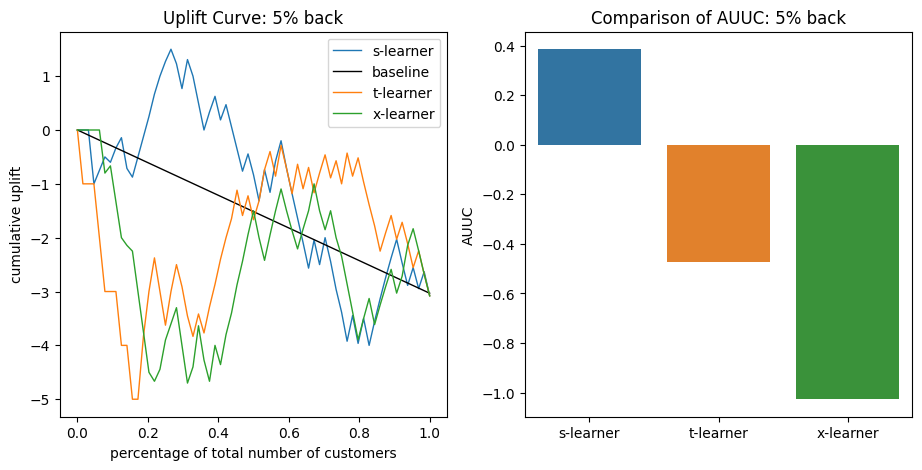

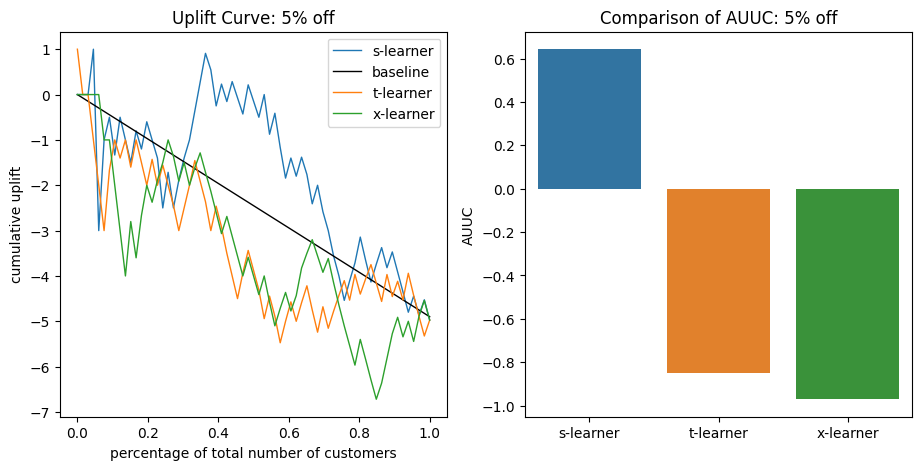

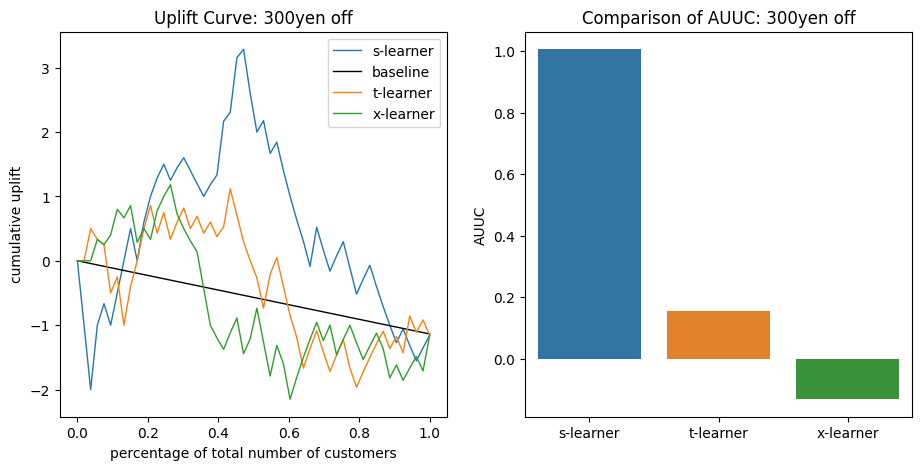

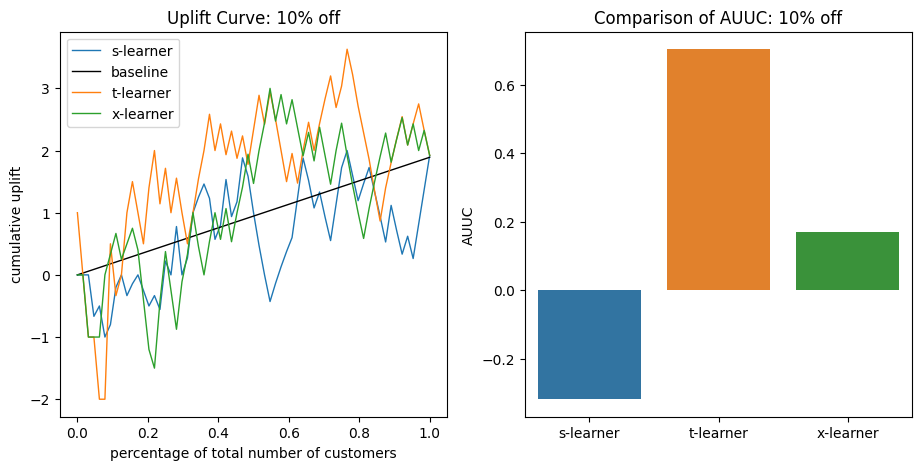

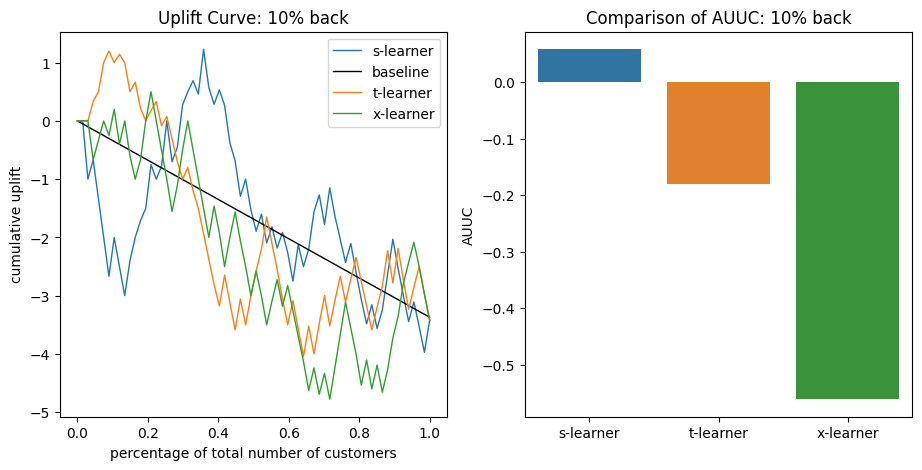

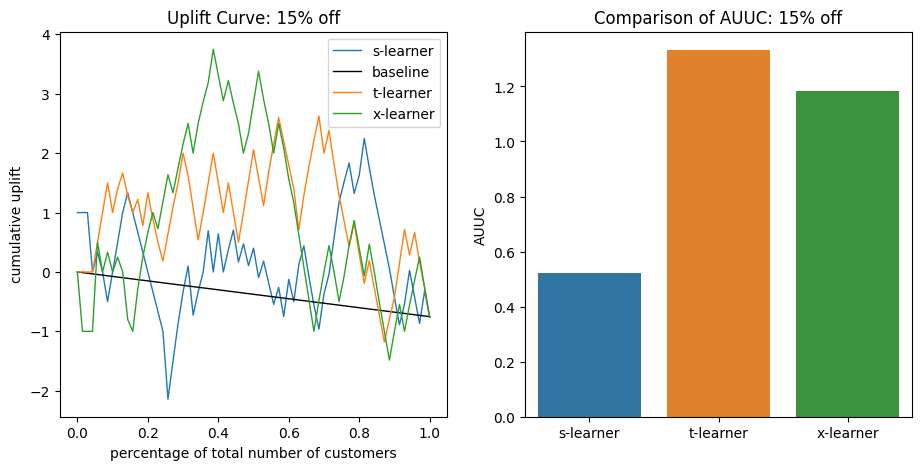

In [3]:
n_treatment = container.test_df[config.treatment_name].nunique() - 1

model_names = ['s-learner', 't-learner', 'x-learner']
treatment_no_list = np.sort(container.test_df[config.treatment_name].unique()).tolist()
treatment_no_list.remove(0)
for i, treatment_no in enumerate(treatment_no_list):    
    fig, axes = plt.subplots(1, 2, figsize=(5*2.2,5))
    uplift_col = f'pred_{treatment_no}'
    counpon_type = postprocess_config.variant_no_to_coupon_type[treatment_no]

    test_index_i = container.test_df.query('treatment in [0, @treatment_no]').index
    test_df_i = container.test_df.loc[test_index_i]
    preds_i = [preds.loc[test_index_i, uplift_col] for preds in container.uplift_preds.values()]
    if config.problem_type == 'classification':
        target_i = test_df_i[config.target_name] > 0
    else:
        target_i = test_df_i[config.target_name]
    treatment_i = test_df_i[config.treatment_name]==treatment_no

    for j, (name, preds_j) in enumerate(zip(model_names, preds_i)):
        plot_uplift_curve(
            target_i, 
            treatment_i,
            preds_j,
            axes[0],
            name,
            True if j==0 else False
        )
    axes[0].set_title(f'Uplift Curve: {counpon_type}')
    auuc_list = [calc_auuc(target_i, treatment_i, preds) for preds in preds_i]
    sns.barplot(y=auuc_list, x=model_names, ax=axes[1])
    axes[1].set_ylabel('AUUC')
    axes[1].set_title(f'Comparison of AUUC: {counpon_type}')
    save_path = str(
        config.dir_config.output_figure_dir / f'uplift_curve_{counpon_type}.png'
    )
    fig.savefig(save_path)

## 最適化の結果
- TODO: evaluation script作る

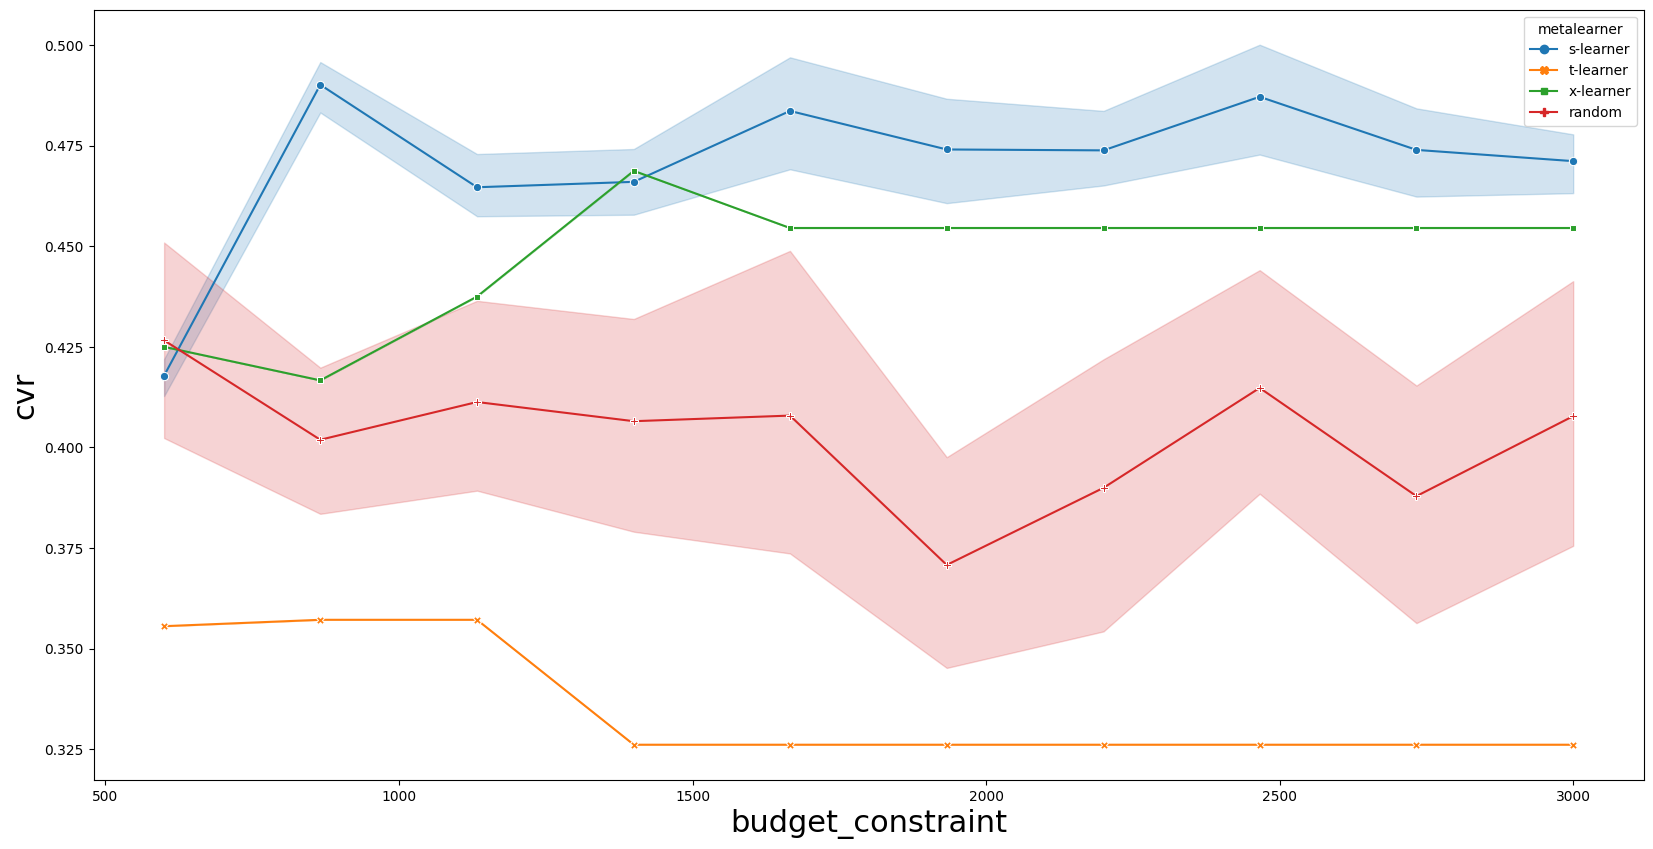

In [4]:
results = []
n_sample = min(container.test_df.shape[0], config.postprocess_config.n_sample)
for name, seed, budget_constraint, assginment in container.assignments:
    sample_idx = container.test_df.sample(n_sample, random_state=seed).index.to_numpy()
    sample_df = container.test_df.loc[sample_idx].copy().reset_index(drop=True)
    if config.problem_type == 'classification':
        sample_df['target'] = sample_df[container.config.target_name] > 0

    # random
    sample_df['cost'] = sample_df[config.treatment_name].map(postprocess_config.variant_no_to_cost)
    assgin_index = (sample_df.sample(frac=1)['cost'].cumsum() > budget_constraint).sort_index()
    sample_df['assginment'] = np.random.randint(0, 7, len(sample_df))
    sample_df.loc[assgin_index, 'assginment'] = 0
    random_cvr = sample_df['target'][(sample_df['assginment']==sample_df[config.treatment_name])].mean() # 一致するものだけでcvr計算
    random_rate = (sample_df['target'][(assginment==sample_df[config.treatment_name])]!=0).mean()
    results.append(['random', seed, budget_constraint, random_cvr, random_rate])   

    cvr = sample_df['target'][
        (assginment==sample_df[config.treatment_name])
        ].mean() # 一致するものだけでcvr計算
    rate = (sample_df['target'][(assginment==sample_df[config.treatment_name])]!=0).mean()
    results.append([name, seed, budget_constraint, cvr, rate])

result_df = pd.DataFrame(results, columns=['metalearner', 'seed', 'budget_constraint', 'cvr', 'assign_rate'])
result_df['budget_constraint'] = result_df['budget_constraint'].astype(int)
result_df = result_df.drop_duplicates().reset_index(drop=True)
result_df['random'] = result_df['metalearner'] == 'random'
result_df = result_df.sort_values(['random', 'metalearner'])

fig, ax = plt.subplots(figsize=(20, 10))
sns.lineplot(data=result_df, y='cvr', x='budget_constraint', hue='metalearner', 
             style='metalearner',
             markers=True, 
             dashes=False,
             ax=ax)
ax.set_xlabel('budget_constraint', fontsize=22)
ax.set_ylabel('cvr',fontsize=22)
fig.savefig(str(config.dir_config.output_figure_dir / 'cvr.png'))